# Covid-19 Survival Analysis

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import random
import matplotlib.pyplot as plt
%matplotlib inline
import lifelines
pd.options.mode.chained_assignment = None
#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick

In [2]:
covid = pd.read_csv('covid19_data_22022021.csv',
        dtype=dict(sex='category',
                   age='string',
                   city='category',
                    province='category',
                    country='category',
                    geo_resolution='category',
                    date_onset_symptoms='category',
                    date_admission_hospital='category',
                    symptoms='string',
                    additional_information='string',
                    date_death_or_discharge='category',
                    travel_history_dates='string',
                    notes_for_discussion='string',
                    latitude=float,
                    longitude=float,
                    lives_in_Wuhan='category',
                    travel_history_location='category',
                    reported_market_exposure='category',
                    chronic_disease_binary='category',
                    chronic_disease='category',
                    source='category',
                    sequence_available='category',
                    outcome='category',
                    #sequence_available=bool,
                    location='category',
                    admin3='category',
                    admin2='category',
                    admin1='category',
                    country_new='category',
                    travel_history_binary='category',
                    data_moderator_initials='category'
                    ),)

In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        572679 non-null  object  
 1   age                       572679 non-null  string  
 2   sex                       572679 non-null  category
 3   city                      524584 non-null  category
 4   province                  564785 non-null  category
 5   country                   572635 non-null  category
 6   latitude                  572679 non-null  float64 
 7   longitude                 572679 non-null  float64 
 8   geo_resolution            572679 non-null  category
 9   date_onset_symptoms       260311 non-null  category
 10  date_admission_hospital   9201 non-null    category
 11  date_confirmation         572410 non-null  object  
 12  symptoms                  1565 non-null    string  
 13  lives_in_Wuhan            162

In [4]:
data = covid.filter(['age', 'sex', 'date_confirmation', 'chronic_disease_binary', 'date_death_or_discharge', 'outcome'])
data.head()

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome
0,78,male,21.02.2020,False,22.02.2020,death
1,61,female,14.02.2020,False,17.02.2020,discharge
2,66,male,07.02.2020,False,NaN,NaN
3,27,female,07.02.2020,False,NaN,NaN
4,17,male,07.02.2020,False,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   age                      572679 non-null  string  
 1   sex                      572679 non-null  category
 2   date_confirmation        572410 non-null  object  
 3   chronic_disease_binary   572679 non-null  category
 4   date_death_or_discharge  3094 non-null    category
 5   outcome                  33601 non-null   category
dtypes: category(4), object(1), string(1)
memory usage: 11.5+ MB


## 1. Data cleaning

### date_death_or_discharge

In [6]:
data['date_death_or_discharge'] = data['date_death_or_discharge'].cat.add_categories('22.02.2021')
data['date_death_or_discharge'].fillna('22.02.2021', inplace =True)
data['date_death_or_discharge'] = pd.to_datetime(data['date_death_or_discharge'])

### date_confirmation

In [7]:
data['date_confirmation'].unique()

array(['21.02.2020', '14.02.2020', '07.02.2020', '08.02.2020',
       '13.02.2020', '12.02.2020', '10.02.2020', '11.02.2020',
       '09.02.2020', '15.02.2020', '16.02.2020', '18.02.2020',
       '06.02.2020', '04.02.2020', '17.02.2020', '22.02.2020',
       '19.02.2020', '20.02.2020', '25.01.2020', '26.01.2020',
       '03.02.2020', '28.01.2020', '23.02.2020', nan, '01.02.2020',
       '31.01.2020', '30.01.2020', '24.01.2020', '26.02.2020',
       '25.02.2020', '24.02.2020', '05.03.2020', '07.03.2020',
       '27.02.2020', '01.03.2020', '28.02.2020', '21.01.2020',
       '04.03.2020', '02.03.2020', '27.01.2020', '02.02.2020',
       '15.01.2020', '03.03.2020', '23.01.2020', '29.02.2020',
       '29.01.2020', '06.03.2020', '05.02.2020',
       '25.02.2020 - 26.02.2020', '11.03.2020', '08.03.2020',
       '06.01.2020', '13.03.2020', '09.03.2020', '10.03.2020',
       '12.03.2020', '14.03.2020', '15.03.2020', '22.01.2020',
       '16.03.2020', '17.03.2020', '16.01.2020', '18.03.2020',
  

In [8]:
data['date_confirmation'].replace(to_replace = '25.02.2020 - 26.02.2020', value = '25.02.2020', inplace = True)
data['date_confirmation'] = pd.to_datetime(data['date_confirmation'])

### Calculate survival duration

In [9]:
data['Duration'] = (data['date_death_or_discharge'] - data['date_confirmation']).dt.days.abs()
data.head()

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome,Duration
0,78,male,2020-02-21,False,2020-02-22,death,1.0
1,61,female,2020-02-14,False,2020-02-17,discharge,3.0
2,66,male,2020-07-02,False,2021-02-22,NaN,235.0
3,27,female,2020-07-02,False,2021-02-22,NaN,235.0
4,17,male,2020-07-02,False,2021-02-22,NaN,235.0


### outcome

In [10]:
data.outcome.drop_duplicates()

0                                                    death
1                                                discharge
2                                                      NaN
342                                             discharged
662                                             Discharged
752                                       not hospitalized
759                                              recovered
766                          recovering at home 03.03.2020
786                               released from quarantine
810                                                 severe
811                                                 stable
1025                                                  died
1101                                                 Death
1176                                                  dead
2137     Symptoms only improved with cough. Currently h...
2175        treated in an intensive care unit (14.02.2020)
3471                                                 Ali

In [11]:
died = ['death', 'Death', 'dead', 'Dead', 'Died', 'Deceased']
data['outcome'].replace(to_replace = died, value = 'died', inplace = True)
data["outcome"]=data["outcome"]=="died"
data.outcome.drop_duplicates()

0     True
1    False
Name: outcome, dtype: bool

### age

In [12]:
age = {'18 months': '2', '18 month': '2', '7 months': '1', '4 months': '0', '13 month': '1', '5 months': '0', '6 months': '1'
       , '9 month': '1', '5 month': '0', '11 month': '1', '8 month': '1', '80+':'85', '90+':'95', '85+': '90'}
data['age'].replace(to_replace=age, value=None, inplace=True)

In [13]:
data[['age1','age2']] = data['age'].str.split('-', n=1, expand=True)
data.age2.fillna(data.age1, inplace=True)
data.age2.unique()

array(['78', '61', '66', '27', '17', '51', '68', '26', '30', '53', '35',
       '28', '58', '33', '50', '45', '24', '88', '29', '21', '52', '60',
       '56', '79', '49', '82', '25', '40', '69', '89', '59', '19', '39',
       '43', '7', '44', '16', '47', '8', '10', '55', '38', '42', '34',
       '62', '71', '64', '36', '31', '1', '48', '54', '65', '46', '57',
       '32', '80', '73', '6', '22', '41', '70', '96', '20', '63', '1.75',
       '75', '0.6666666667', '12', '77', '18', '72', '4', '95', '37',
       '23', '99', '85', '91', '87', '14', '76', '94', '0.5', '0.25',
       '67', '15', '9', '13', '74', '81', '11', '5', '84', '86', '', '83',
       '2', '100', ' 100', '3', '93', '92', '97', '0.08333', '105', '0',
       '0.75', '90', '101', '98', '39.0', '44.0', '54.0', '45.0', '30.0',
       '33.0', '50.0', '20.0', '53.0', '46.0', '31.0', '35.0', '80.0',
       '72.0', '24.0', '37.0', '27.0', '65.0', '28.0', '40.0', '34.0',
       '36.0', '41.0', '38.0', '57.0', '32.0', '52.0', '47.0

In [14]:
del data['age']

In [15]:
data['age1'] = pd.to_numeric(data['age1'])
data['age2'] = pd.to_numeric(data['age2'])
data.age2.unique()

array([7.80000000e+01, 6.10000000e+01, 6.60000000e+01, 2.70000000e+01,
       1.70000000e+01, 5.10000000e+01, 6.80000000e+01, 2.60000000e+01,
       3.00000000e+01, 5.30000000e+01, 3.50000000e+01, 2.80000000e+01,
       5.80000000e+01, 3.30000000e+01, 5.00000000e+01, 4.50000000e+01,
       2.40000000e+01, 8.80000000e+01, 2.90000000e+01, 2.10000000e+01,
       5.20000000e+01, 6.00000000e+01, 5.60000000e+01, 7.90000000e+01,
       4.90000000e+01, 8.20000000e+01, 2.50000000e+01, 4.00000000e+01,
       6.90000000e+01, 8.90000000e+01, 5.90000000e+01, 1.90000000e+01,
       3.90000000e+01, 4.30000000e+01, 7.00000000e+00, 4.40000000e+01,
       1.60000000e+01, 4.70000000e+01, 8.00000000e+00, 1.00000000e+01,
       5.50000000e+01, 3.80000000e+01, 4.20000000e+01, 3.40000000e+01,
       6.20000000e+01, 7.10000000e+01, 6.40000000e+01, 3.60000000e+01,
       3.10000000e+01, 1.00000000e+00, 4.80000000e+01, 5.40000000e+01,
       6.50000000e+01, 4.60000000e+01, 5.70000000e+01, 3.20000000e+01,
      

In [16]:
col = data.loc[: , 'age1':'age2']
data['age3'] = col.mean(axis=1)
data.head()

,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome,Duration,age1,age2,age3
0,male,2020-02-21,False,2020-02-22,True,1.0,78.0,78.0,78.0
1,female,2020-02-14,False,2020-02-17,False,3.0,61.0,61.0,61.0
2,male,2020-07-02,False,2021-02-22,False,235.0,66.0,66.0,66.0
3,female,2020-07-02,False,2021-02-22,False,235.0,27.0,27.0,27.0
4,male,2020-07-02,False,2021-02-22,False,235.0,17.0,17.0,17.0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   sex                      572679 non-null  category      
 1   date_confirmation        572410 non-null  datetime64[ns]
 2   chronic_disease_binary   572679 non-null  category      
 3   date_death_or_discharge  572679 non-null  datetime64[ns]
 4   outcome                  572679 non-null  bool          
 5   Duration                 572410 non-null  float64       
 6   age1                     572679 non-null  float64       
 7   age2                     572631 non-null  float64       
 8   age3                     572679 non-null  float64       
dtypes: bool(1), category(2), datetime64[ns](2), float64(4)
memory usage: 27.9 MB


### Other variables, NA, count outcome value

In [18]:
data['chronic_disease_binary']=data['chronic_disease_binary']=='True'

In [19]:
data.sex.unique()

['male', 'female']
Categories (2, object): ['male', 'female']

In [20]:
#Drop NA
data.dropna(inplace=True)

In [21]:
data.outcome.value_counts()

False    571035
True       1327
Name: outcome, dtype: int64

## 2. Data Exploration

### Dead vs. Survived Patients

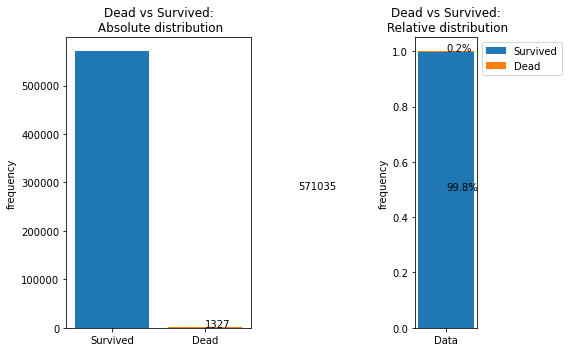

In [22]:
keys, counts = np.unique(data.outcome, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Survived', 'Dead'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Dead vs Survived:\n Absolute distribution') 
ax0 = plt.ylabel('frequency')
ax0 = plt.text(['Survive'], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(['Dead'], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='Survived')
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Dead')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Dead vs Survived:\n Relative distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

### Deaths by Gender

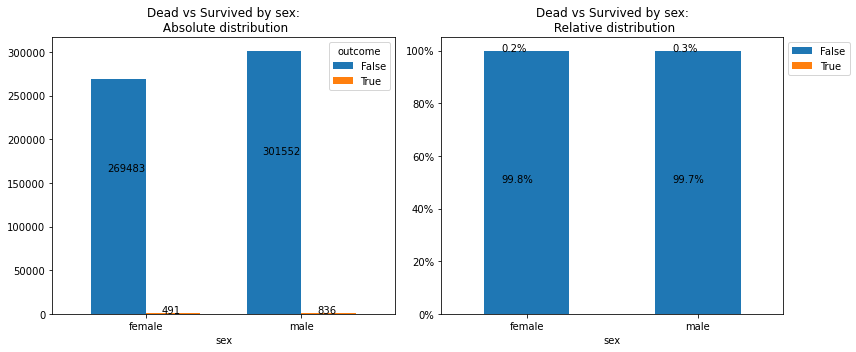

In [23]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['sex', 'outcome'])['outcome'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Dead vs Survived by sex:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['sex','outcome'])['outcome'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Dead vs Survived by sex:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

### Deaths by Age Group

In [24]:
data['age group'] = np.where(data.age3 <= 40, 'young', np.where(data.age3 <=65, 'middle', 'old'))

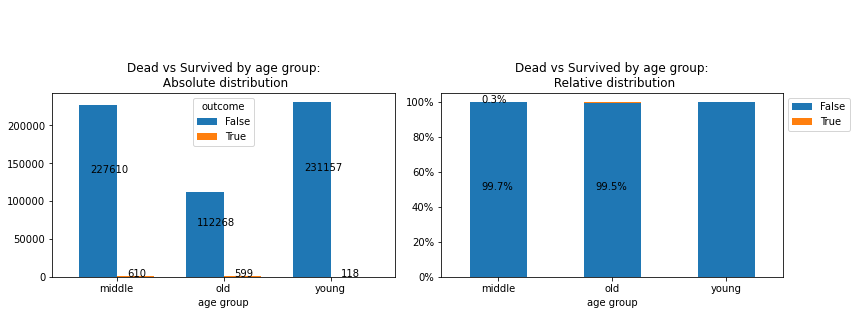

In [25]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['age group', 'outcome'])['outcome'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Dead vs Survived by age group:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['age group','outcome'])['outcome'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Dead vs Survived by age group:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

### Deaths by Chronic Deseases

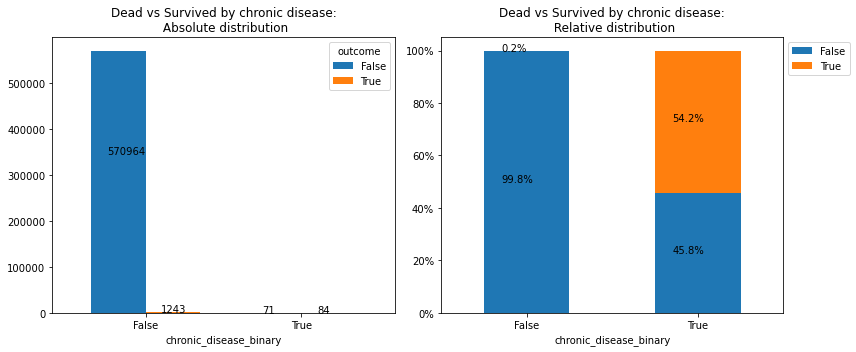

In [26]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['chronic_disease_binary', 'outcome'])['outcome'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Dead vs Survived by chronic disease:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['chronic_disease_binary','outcome'])['outcome'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Dead vs Survived by chronic disease:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

## 3. Analysis

### 3.1 Kaplan-Meier estimator for survival function

#### Kaplan Meier curve

KeyError: "None of [Index(['At risk', 'Censored', 'Events'], dtype='object')] are in the [index]"

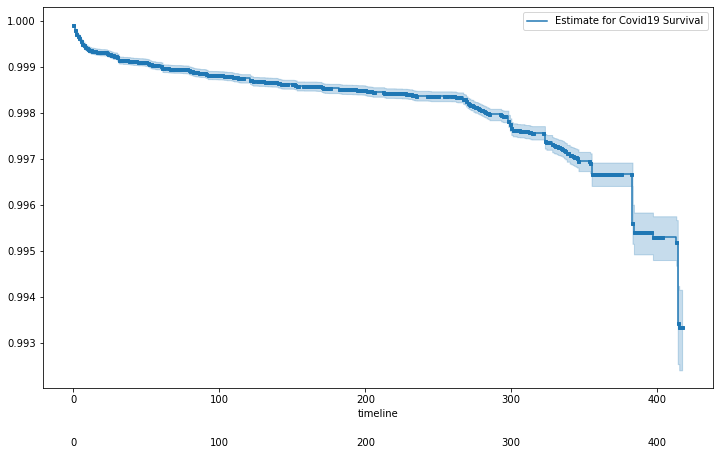

In [28]:
# fitting kmf to the data
days = data['Duration'].values
outcome = data['outcome'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(days, event_observed=outcome, label='Estimate for Covid19 Survival')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(12,7))
kmf.plot(ax=ax,show_censors=True, censor_styles={'ms': 3, 'marker': 's'},at_risk_counts=True)
ax.set_title('Kaplan-Meier Survival Curve - Covid19')
ax.set_xlabel('Covid19 Duration Time (Days)')
ax.set_ylabel('Covid19 Survival Chance (%)')
plt.show()

The y-axis represents the probability a patient is survived after 𝑡 days, where 𝑡 days is on the x-axis. It  can be observed that from day 275th (approximately), there is a noticeable drop in patients’ survival chance especially after day 375 (approximately).

#### KM curve and log-rank test for female and male

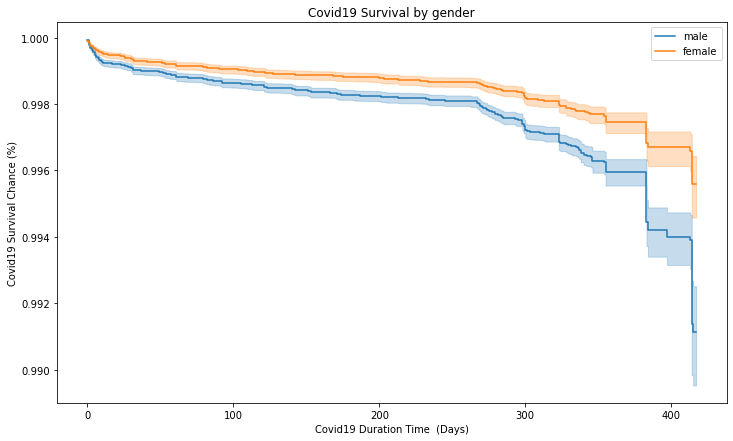

In [29]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='Duration', event='outcome', df=data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)
        
# plot by gender
fig_gen, ax_gen = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='sex', ax=ax_gen)
ax_gen.set_title('Covid19 Survival by gender')
ax_gen.set_xlabel('Covid19 Duration Time  (Days)')
ax_gen.set_ylabel('Covid19 Survival Chance (%)')
plt.show()

In [30]:
female = (data["sex"] == "female")
T = data["Duration"]
E = data["outcome"]
kmf.fit(T[female], event_observed=E[female])

from lifelines.statistics import logrank_test

gender_results = logrank_test(T[female], T[~female], E[female], E[~female], alpha=.99)


gender_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          60.98 <0.005     47.30

Female patients have larger survival probability than male. The survival probability for male also seems to decrease more gradually than that of female. The log-rank test result gives test-statistic of 60.98 and p-value below 0.005, which indicates that there is a statistically significant difference between the survival functions of two sex groups.

#### KM curve and log-rank test for Age Group

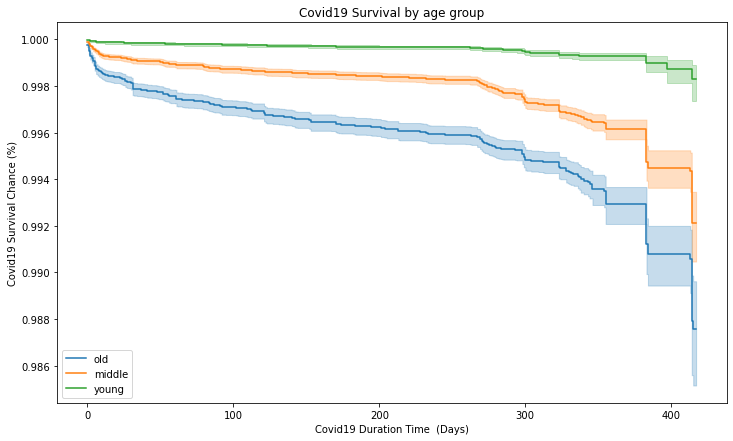

In [31]:
# plot by age group
fig_edl, ax_edl = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='age group', ax=ax_edl)
ax_edl.set_title('Covid19 Survival by age group')
ax_edl.set_xlabel('Covid19 Duration Time  (Days)')
ax_edl.set_ylabel('Covid19 Survival Chance (%)')
plt.show()

In [32]:
from lifelines.statistics import multivariate_logrank_test
results = multivariate_logrank_test(data['Duration'], data['age group'], data['outcome'])
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         708.62 <0.005    511.16

Old age group has the lowest survival chance, followed by middle age group and young age group has the highest. While the survival probability for young and middle age group are rather stable at from day 1 to day 275, that of old age group seems to decrease more quickly. The log-rank test result gives test-statistic of 708.62 and p-value below 0.005, which indicates that there is a statistically significant discrepancies among the survival functions of the 3 age groups.

### 3.1 Cox Regression

#### Cox model with sex as the only covariate

In [33]:
task_i = ['outcome', 'sex','Duration']
data2 = data[task_i]
data2.head()

,outcome,sex,Duration
0,True,male,1.0
1,False,female,3.0
2,False,male,235.0
3,False,female,235.0
4,False,male,235.0


In [34]:
#change the binary variables to True and False
data2['sex'] = data2['sex'] == 'female'
    
# Building training and testing sets
from sklearn.model_selection import train_test_split
random.seed(10)

data2_train,data2_test = train_test_split(data2,test_size=0.35)
data2_cph = lifelines.CoxPHFitter()
data2_cph.fit(data2_train, duration_col='Duration', event_col='outcome', show_progress=False)
data2_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 372035 total observations, 371182 right-censored observations>
             duration col = 'Duration'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 372035
number of events observed = 853
   partial log-likelihood = -10567.89
         time fit was run = 2022-05-29 00:12:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.37       0.69       0.07            -0.51            -0.23                 0.60                 0.79

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -5.28 <0.005      22.90
---
Concordance = 0.54
Partial AIC = 21137.78
log-likelihood ratio test = 28.54 on 1 df
-log2(p) of ll-ratio test = 23.38

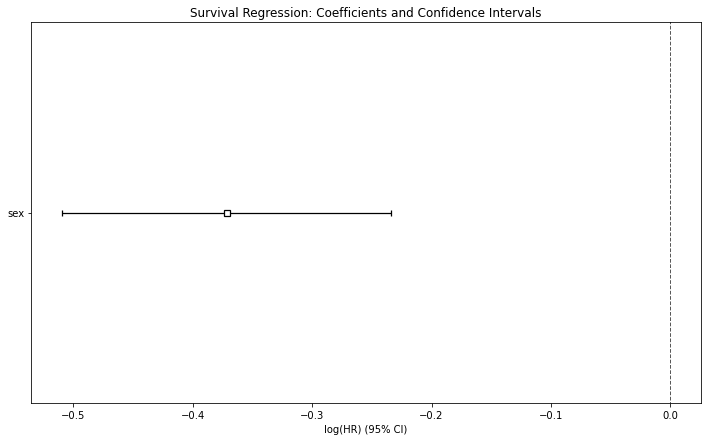

In [35]:
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals')
data2_cph.plot(ax=ax_coef);

<AxesSubplot:>

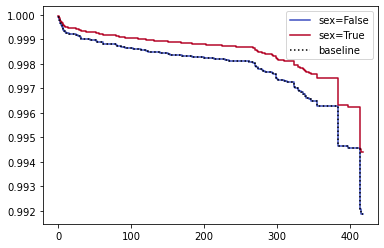

In [36]:
# check covariate group 
data2_cph.plot_partial_effects_on_outcome('sex', [False,True], cmap='coolwarm')

Female data takes True value and male False. The coefficient takes a negative value, so female group has a higher chance of survival than male group. The relative risk for the female patients is exp{−0.38} = 0.69, that is, the male patients would have 1.4 (1/0.69) times more death risk than female patients.

#### Cox model with sex as a stratify variable and age groups as a covariate

In [37]:
task_j = ['age group', 'outcome', 'sex','Duration']
data3 = data[task_j]

# encode the categorical feature
data3 = pd.get_dummies(data3, drop_first=True, columns=['age group'], prefix=['age group'])
data3.head()

,outcome,sex,Duration,age group_old,age group_young
0,True,male,1.0,1,0
1,False,female,3.0,0,0
2,False,male,235.0,1,0
3,False,female,235.0,0,1
4,False,male,235.0,0,1


In [38]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
rossi = load_rossi()

data3_train,data3_test = train_test_split(data3,test_size=0.35)
data3_cph = CoxPHFitter()
data3_cph.fit(data3_train, 'Duration', event_col='outcome', strata=['sex'])
data3_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 372035 total observations, 371187 right-censored observations>
             duration col = 'Duration'
                event col = 'outcome'
                   strata = ['sex']
      baseline estimation = breslow
   number of observations = 372035
number of events observed = 848
   partial log-likelihood = -9711.09
         time fit was run = 2022-05-29 00:16:00 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age group_old     0.62       1.85       0.07             0.48             0.76                 1.61                 2.13
age group_young  -1.70       0.18       0.13            -1.95            -1.45                 0.14                 0.23

                  cmp to      z      p   -log2(p)
covariate                                        
age group_old       0.00   8.57 <0.005      56.42
age group_young     0.00 -13.31 <0.005     131.81
---
Concordance = 0.70
Partial AIC = 19426.19
log-likelihood ratio test = 490.82 on 2 df
-log2(p) of ll-ratio test = 354.05

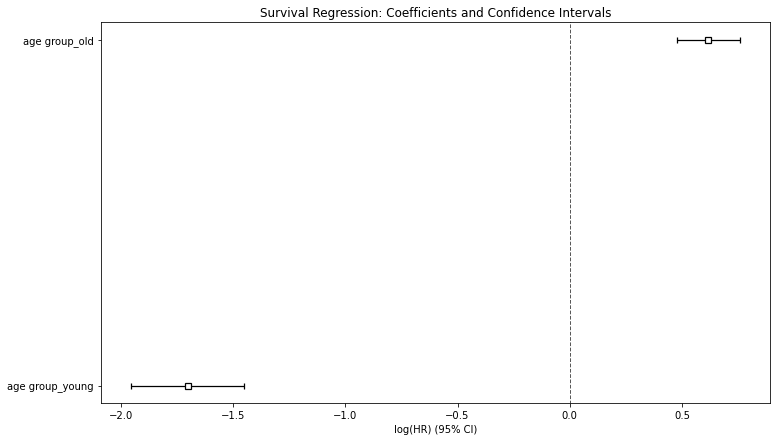

In [39]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals')
data3_cph.plot(ax=ax_coef);

[<AxesSubplot:>, <AxesSubplot:>]

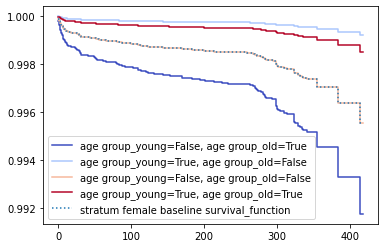

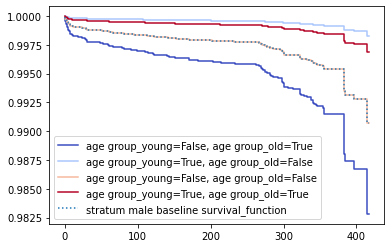

In [40]:
# check multiple covariates
data3_cph.plot_partial_effects_on_outcome(['age group_young','age group_old'], [[False,True],[True,False],[False,False],[True,True]], cmap='coolwarm')

We can observe that for both male and female groups, young age group (age group_young=True, age group_old=False) has the
highest chance of survival, old age group (age group_young=False, age group_old=True) has the lowest chance of survival, and middle age group (age group_young=False, age group_old=True) has higher chance of survival than old age group and lower chance than young age group. The difference in 3 survival functions is statistically significant (p-value < 0.005). The relative risk for old patients is exp{0.75} = 2.12, that is, old patients would have 2.12 times more death risk than other patients. On the contrary, the relative risk for young patients is exp{-1.63} = 0.20, indicating that other patients would have 5 (1/0.2) times more death risk than young patients.